In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

ola_df = pd.read_pickle("OLA_data.pkl")
gps_df = pd.read_pickle("GPS_data.pkl")
pwm_df = pd.read_pickle("PWM_data.pkl")

In [73]:
# make some useful functions
def haversine(lat1, lon1, lat2, lon2):
      R = 6372.8 #km
      dLat = math.radians(lat2 - lat1)
      dLon = math.radians(lon2 - lon1)
      lat1 = math.radians(lat1)
      lat2 = math.radians(lat2)
      a = math.sin(dLat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dLon/2)**2
      c = 2*math.asin(math.sqrt(a))
      return R * c

def bearing(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    Bearing = math.atan2(math.sin(dlon)*math.cos(lat2), 
                         math.cos(lat1)*math.sin(lat2)-math.sin(lat1)*math.cos(lat2)*math.cos(dlon))

    return Bearing

# function to get altitide
def get_alt_at_ll(dted, lat, lon):
    dlat = 1.0 - (lat - 36.0)
    dlon = lon - -122.0
    n_pix = dted.shape[0]
    deg_step = 1.0 / n_pix
        
    p_lat = int(n_pix * dlat)
    p_lon = int(n_pix * dlon)
    
    deltas = [-1,0,-1]
    sum_num = 0.0
    sum_den = 0.0
    for xi in deltas:
        for yi in deltas:
            s_lon = -122.0 + (p_lon+xi)*deg_step
            s_lat = 36.0 + (p_lat+yi)*deg_step
            s_alt = dted[int(p_lat + yi), int(p_lon + xi)]
            dist = haversine(s_lat, s_lon, lat, lon)
            sum_num += s_alt / dist
            sum_den += 1/dist
            
    return sum_num / sum_den

In [85]:
ll = 20.0 # GPS becomes good at ~20.0s
ul = 125.0 # OLA goes bad just after ~125.0s

ola_ll_ind = np.argmin(np.abs(ola_df.Wall_Time - ll))
print("OLA LL Ind: ", ola_ll_ind)
pwm_ll_ind = np.argmin(np.abs(pwm_df.Wall_Time - ll))
print("PWM LL Ind: ", pwm_ll_ind)
gps_ll_ind = np.argmin(np.abs(gps_df.Wall_Time - ll))
print("GPS LL Ind: ", gps_ll_ind)


ola_ul_ind = np.argmin(np.abs(ola_df.Wall_Time - ul))
print("OLA UL Ind: ", ola_ul_ind)
pwm_ul_ind = np.argmin(np.abs(pwm_df.Wall_Time - ul))
print("PWM UL Ind: ", pwm_ul_ind)
gps_ul_ind = np.argmin(np.abs(gps_df.Wall_Time - ul))
print("GPS UL Ind: ", gps_ul_ind)

pwm_rate = (pwm_ul_ind - pwm_ll_ind) / (ul-ll)
gps_rate = (gps_ul_ind - gps_ll_ind) / (ul-ll)
ola_rate = (ola_ul_ind - ola_ll_ind) / (ul-ll)

print("PWM Rate: ", pwm_rate, " Hz")
print("GPS Rate: ", gps_rate, " Hz")
print("OLA Rate: ", ola_rate, " Hz")


OLA LL Ind:  532
PWM LL Ind:  348
GPS LL Ind:  73
OLA UL Ind:  3871
PWM UL Ind:  2428
GPS UL Ind:  347
PWM Rate:  19.80952380952381  Hz
GPS Rate:  2.6095238095238096  Hz
OLA Rate:  31.8  Hz


In [75]:
# convert to meters based upon the center point of the course
m_lon = gps_df.Lon[gps_ll_ind:gps_ul_ind].mean()
m_lat = gps_df.Lat[gps_ll_ind:gps_ul_ind].mean()
m_alt = gps_df.Altitude[gps_ll_ind:gps_ul_ind].mean()

gps_df["dist2center"] = gps_df.apply(lambda x: 1000.0 * haversine(x.Lat, x.Lon, m_lat, m_lon), axis=1)
gps_df["bearing2center"] = gps_df.apply(lambda x: bearing(m_lat, m_lon, x.Lat, x.Lon), axis=1)
gps_df["x"] = gps_df.apply(lambda x: math.sin(x["bearing2center"]) * x["dist2center"], axis=1)
gps_df["y"] = gps_df.apply(lambda x: math.cos(x["bearing2center"]) * x["dist2center"], axis=1)
gps_df["z"] = gps_df.apply(lambda x: x.Altitude - m_alt, axis=1)

temp = gps_df.shift(-1)
temp.iloc[-1] = temp.iloc[0]

gps_df["next_x"] = temp["x"]
gps_df["next_y"] = temp["y"]
gps_df["next_z"] = temp["z"]
gps_df["next_T"] = temp.Wall_Time
gps_df["dist_to_next"] = gps_df.apply(lambda x: math.sqrt((x.next_x - x.x)**2 + (x.next_y - x.y)**2), axis=1)
gps_df["time_to_next"] = gps_df.apply(lambda x: x.next_T - x.Wall_Time, axis=1)
gps_df["Speed"] = gps_df.apply(lambda x: x.dist_to_next / x.time_to_next, axis=1)

# gps_df["uv_to_next"] = gps_df.apply(lambda x: np.array([(x["next_x"] - x["x"])/x["dist_to_next"], (x["next_y"] - x["y"])/x["dist_to_next"]]), axis=1)
# gps_df["step_to_next"] = gps_df.apply(lambda x: np.array([x["next_x"] - x["x"], x["next_y"] - x["y"]]), axis=1)
# gps_df["bearing_to_next"] = gps_df.apply(lambda x: math.atan2(x["next_y"] - x["y"], x["next_x"] - x["x"]), axis=1)

gps_df["cum_distance"] = gps_df["dist_to_next"].cumsum()

gps_df

,Wall_Time,header,utc time,Lat,Lat_Dir,Lon,Lon _Dir,Quality_Indicator,Satellites Used,HDOP,...,y,z,next_x,next_y,next_z,next_T,dist_to_next,time_to_next,Speed,cum_distance
0,0.061255,$GNGGA,1923.0,39.439148,N,-119.784993,W,2,10,0.85,...,8.130893,-2.913139,7.958558,8.112356,-2.913139,0.155998,0.023423,0.094743,0.247222,0.023423
1,0.155998,$GNGGA,1923.1,39.439148,N,-119.784993,W,2,10,0.85,...,8.112356,-2.913139,7.944241,8.093818,-2.813139,0.249403,0.023423,0.093406,0.250761,0.046845
2,0.249403,$GNGGA,1923.2,39.439147,N,-119.784993,W,2,10,0.85,...,8.093818,-2.813139,7.929925,8.093818,-2.813139,0.345967,0.014317,0.096564,0.148261,0.061162
3,0.345967,$GNGGA,1923.3,39.439147,N,-119.784993,W,2,10,0.85,...,8.093818,-2.813139,7.901291,8.075280,-2.713139,0.445411,0.034110,0.099444,0.343010,0.095272
4,0.445411,$GNGGA,1923.4,39.439147,N,-119.784993,W,2,10,0.85,...,8.075280,-2.713139,7.886975,8.056742,-2.713139,0.546006,0.023423,0.100595,0.232840,0.118695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,298.825595,$GNGGA,2420.3,39.439152,N,-119.784967,W,2,10,0.87,...,8.612877,-10.313139,10.191959,8.612877,-10.313139,299.094071,0.000000,0.268476,0.000000,393.078642
878,299.094071,$GNGGA,2420.4,39.439152,N,-119.784967,W,2,10,0.87,...,8.612877,-10.313139,10.191959,8.631414,-10.213139,299.379227,0.018538,0.285156,0.065009,393.097179
879,299.379227,$GNGGA,2420.5,39.439152,N,-119.784967,W,2,10,0.87,...,8.631414,-10.213139,10.177643,8.631414,-10.213139,299.651505,0.014317,0.272278,0.052581,393.111496
880,299.651505,$GNGGA,2420.6,39.439152,N,-119.784967,W,2,9,0.92,...,8.631414,-10.213139,10.177643,8.649952,-10.113139,299.922337,0.018538,0.270832,0.068447,393.130034


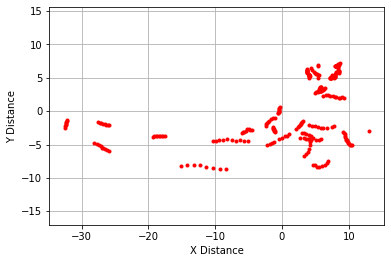

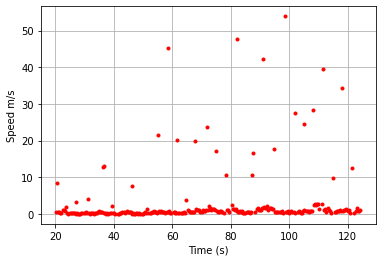

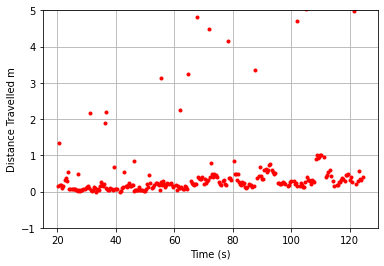

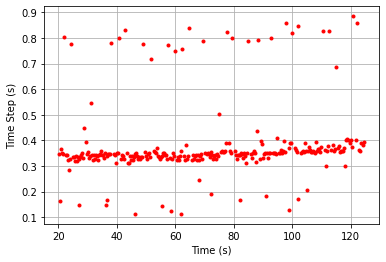

median GPS rate:  3.0643048243595308  Hz


In [76]:
plt.plot(gps_df.x[gps_ll_ind:gps_ul_ind], gps_df.y[gps_ll_ind:gps_ul_ind], 'r.')
plt.axis('equal')
plt.xlabel("X Distance")
plt.ylabel("Y Distance")
plt.grid()
plt.show()

plt.plot(gps_df.Wall_Time[gps_ll_ind:gps_ul_ind], gps_df.Speed[gps_ll_ind:gps_ul_ind], 'r.')
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Speed m/s")
# plt.ylim([0., 5])
plt.show()

plt.plot(gps_df.Wall_Time[gps_ll_ind:gps_ul_ind], gps_df.dist_to_next[gps_ll_ind:gps_ul_ind], 'r.')
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Distance Travelled m")
plt.ylim([-1, 5])
plt.show()

plt.plot(gps_df.Wall_Time[gps_ll_ind:gps_ul_ind], gps_df.time_to_next[gps_ll_ind:gps_ul_ind], 'r.')
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Time Step (s)")
plt.show()
print("median GPS rate: ", 1.0 / gps_df.time_to_next.median(), " Hz")

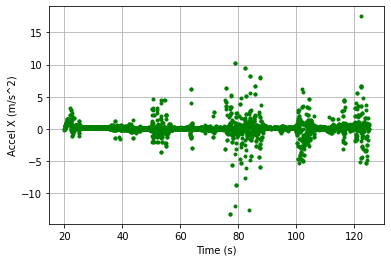

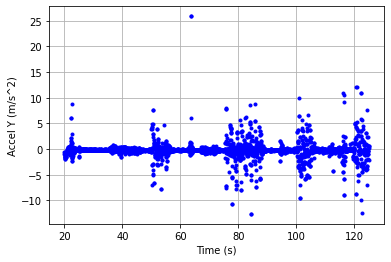

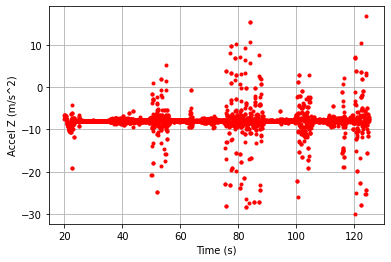

0.152


In [83]:
# plt.plot(pwm_df.Wall_Time, pwm_df.Steer)
plt.plot(ola_df.Wall_Time[ola_ll_ind:ola_ul_ind], ola_df.RawAX[ola_ll_ind:ola_ul_ind]/1000.0, 'g.')
plt.xlabel("Time (s)")
plt.ylabel("Accel X (m/s^2)")
plt.grid()
plt.show()
plt.plot(ola_df.Wall_Time[ola_ll_ind:ola_ul_ind], ola_df.RawAY[ola_ll_ind:ola_ul_ind]/1000.0, 'b.')
plt.xlabel("Time (s)")
plt.ylabel("Accel Y (m/s^2)")
plt.grid()
plt.show()
plt.plot(ola_df.Wall_Time[ola_ll_ind:ola_ul_ind], ola_df.RawAZ[ola_ll_ind:ola_ul_ind]/1000.0, 'r.')
plt.xlabel("Time (s)")
plt.ylabel("Accel Z (m/s^2)")
plt.grid()
plt.show()

print(np.median(ola_df.RawAX/1000.0))


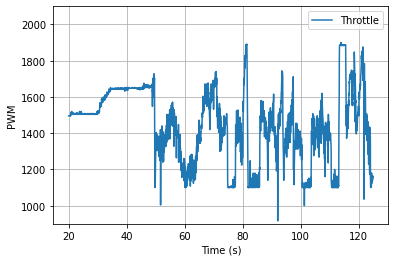

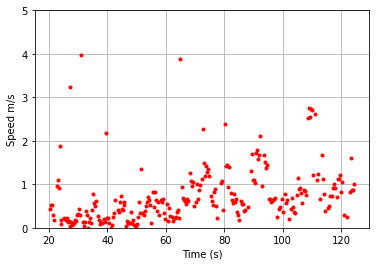

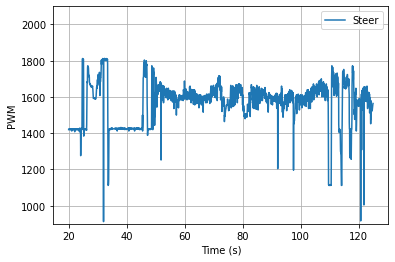

In [89]:
plt.plot(pwm_df.Wall_Time[pwm_ll_ind:pwm_ul_ind], pwm_df.Steer[pwm_ll_ind:pwm_ul_ind], label='Throttle')
# plt.plot(pwm_df.Wall_Time[pwm_ll_ind:pwm_ul_ind], pwm_df.Throttle[pwm_ll_ind:pwm_ul_ind], label='Throttle')
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("PWM")
plt.ylim([900, 2100])
plt.legend()
plt.show()

plt.plot(gps_df.Wall_Time[gps_ll_ind:gps_ul_ind], gps_df.Speed[gps_ll_ind:gps_ul_ind], 'r.')
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Speed m/s")
plt.ylim([0., 5])
plt.show()


plt.plot(pwm_df.Wall_Time[pwm_ll_ind:pwm_ul_ind], pwm_df.Throttle[pwm_ll_ind:pwm_ul_ind], label='Steer')
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("PWM")
plt.ylim([900, 2100])
plt.legend()
plt.show()


gps_df.columns:  Index(['Wall_Time', 'header', 'utc time', 'Lat', 'Lat_Dir', 'Lon', 'Lon _Dir',
       'Quality_Indicator', 'Satellites Used', 'HDOP', 'Altitude', 'Alt_units',
       'Geoidal_Separation', 'GS_units', 'DGPS_Station_ID', 'checksum',
       'dist2center', 'bearing2center', 'x', 'y', 'z', 'next_x', 'next_y',
       'next_z', 'next_T', 'dist_to_next', 'time_to_next', 'Speed',
       'cum_distance'],
      dtype='object')


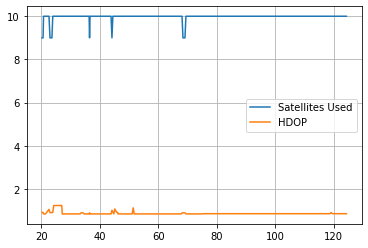

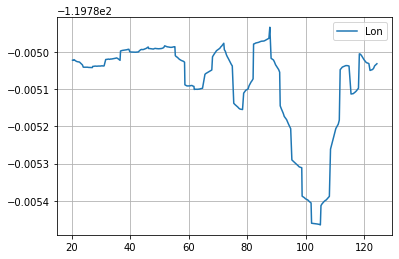

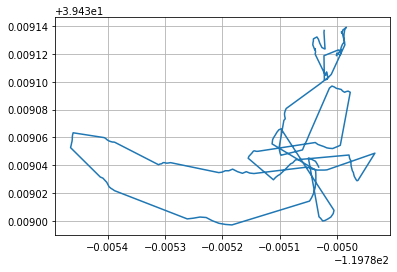

In [79]:
print("gps_df.columns: ", gps_df.columns)
plt.plot(gps_df.Wall_Time[gps_ll_ind:gps_ul_ind], gps_df['Satellites Used'][gps_ll_ind:gps_ul_ind], label="Satellites Used")
plt.plot(gps_df.Wall_Time[gps_ll_ind:gps_ul_ind], gps_df.HDOP[gps_ll_ind:gps_ul_ind], label="HDOP")
plt.grid()
plt.legend()
plt.show()

# plt.plot(gps_df.Wall_Time[gps_ll_ind:gps_ul_ind], gps_df.Lat[gps_ll_ind:gps_ul_ind], label="Lat")
plt.plot(gps_df.Wall_Time[gps_ll_ind:gps_ul_ind], gps_df.Lon[gps_ll_ind:gps_ul_ind], label="Lon")
plt.grid()
plt.legend()
plt.show()


plt.plot(gps_df.Lon[gps_ll_ind:gps_ul_ind], gps_df.Lat[gps_ll_ind:gps_ul_ind])
# plt.axis('equal')
plt.grid()
plt.show()


In [80]:
#https://pymoo.org/getting_started/part_3.html
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.pso import PSO # particle swarm
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize



class TireTemperatureOptmization(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=3,
                         n_obj=1,
                         n_ieq_constr=0,
                         xl=np.array([100, 0, 100]),
                         xu=np.array([500.0,10, 200]))

    def _evaluate(self, x, out, *args, **kwargs):
        timestep = 0.01
        tire_temp = log_df["Tire Temp (C)"].iloc[0]
        ground_temp = 31.11
        ambient_temp = 21.12
        err = 0.0
        # temps = []
        for i in range(len(log_df["Tire Temp (C)"])):
            speed = log_df["Speed (m/s)"].iloc[i]
            heat_generated = np.sum([log_df["Down Force (N)"].iloc[i] + 8.0*9.81,
                                        log_df["Drag Force (N)"].iloc[i] + log_df["Acceleration (m/s^2)"].iloc[i],
                                        log_df["Perp Force (N)"].iloc[i]]) * tire.tire_hysteresis_coeff * speed
            heat_expelled_convection = x[0] * tire.surface_area * (tire_temp - ambient_temp) # rate of heat expulsion - W - J/
            heat_expelled_conduction = x[1] * tire.contact_patch * (tire_temp - ground_temp) # rate of heat expulsion - W - J/s
            heat_diff = heat_generated - (heat_expelled_convection + heat_expelled_conduction)
            tire_temp = (heat_diff * timestep) / x[2] + tire_temp # deg C
            # temps.append(tire_temp)
            err += abs(log_df["Tire Temp (C)"].iloc[i] - tire_temp)
        
        f1 = err# / len(log_df["Motor Temp (C)"])
        out["F"] = [f1]
        out["G"] = []


problem = TireTemperatureOptmization()

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

alg2 = PSO() # PSO can't be used on multiobjective optimization


termination = get_termination("n_gen", 40)

res = minimize(problem,
               alg2,#algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

x = res.X
F = res.F

r_x = np.array([tire.h_convection,
              tire.h_conduction,
              tire.specific_heat_mass
              ])

print("F: ", F)
print("Recorded X: ", r_x)
print("Estimate X: ", x)
print("Diff: ", abs(x - r_x))

ModuleNotFoundError: No module named 'pymoo'